In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import requests
import io

In [2]:
plt.rcParams.update({'font.size': 14})

# European Monetary Union #

## M2 Monetary Aggregate ##

In [3]:
# Fetch data from the ECB
# https://sdw.ecb.europa.eu/browse.do?node=bbn3501
resp = requests.get('https://sdw.ecb.europa.eu/quickviewexport.do?SERIES_KEY=117.BSI.M.U2.N.V.M20.X.1.U2.2300.Z01.E&type=csv')
fp = io.StringIO(resp.text)
df = pd.read_csv(fp, skiprows=5, header=None, names=['month', 'm2_million_euro'])

In [4]:
df['date'] = pd.to_datetime(df['month'], format='%Y%b')
df = df[['date', 'm2_million_euro']]
df['m2'] = df['m2_million_euro'] / 1e3
m2 = df

In [5]:
def plot_m2(df, start_date, zone, currency):
    sel = df[df['date'] > start_date].copy()
    sel = sel.sort_values('date', ascending=False).reset_index(drop=True)
    sel['value_ratio'] = sel['m2'].loc[len(sel)-1] / sel['m2']
    fig, ax = plt.subplots(figsize=(12, 7))
    sel.plot(x='date', y='m2', label=f'{zone} M2 Monetary Aggregate', ax=ax)
    plt.ylabel(f'Billion {currency}')
    plt.xlabel('')
    plt.grid(linestyle=':')
    ax2 = sel.plot(x='date', y='value_ratio', label='Inverted M2, norm. to 1', ax=ax, secondary_y=True, color = 'red', linestyle='--')
    ax.grid(linestyle=':')
    #ax2.grid(None)
    #plt.legend(['Eurozone M2 Monetary Aggregate'])


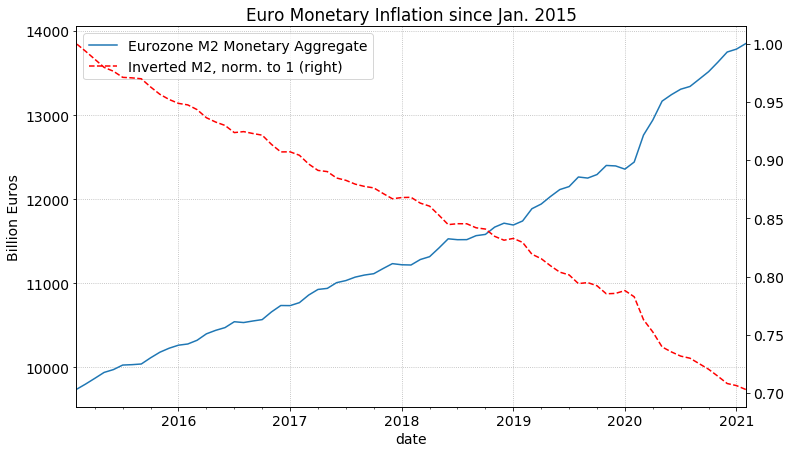

In [6]:
plot_m2(m2, '2015-01-01', 'Eurozone', 'Euros')
plt.title('Euro Monetary Inflation since Jan. 2015')
plt.show()

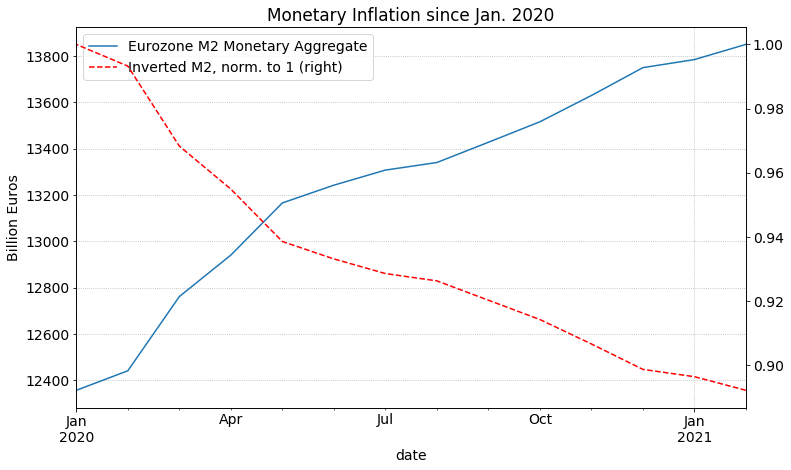

In [7]:
plot_m2(m2, '2019-12-31', 'Eurozone', 'Euros')
plt.title('Monetary Inflation since Jan. 2020')
plt.show()

## M2 Relative to GDP ##

In [8]:
# Fetch data from the ECB
# https://sdw.ecb.europa.eu/browse.do?node=bbn3501
resp = requests.get('https://sdw.ecb.europa.eu/quickviewexport.do?SERIES_KEY=139.AME.A.EA19.1.0.0.0.OVGD&type=csv')
fp = io.StringIO(resp.text)
df = pd.read_csv(fp, skiprows=5, header=None, names=['year', 'gdp'])

In [9]:
gdp = df
gdp['date'] = pd.to_datetime(gdp['year'], format='%Y')

In [10]:
def plot_gdp(m2, gdp, start_date, end_date, currency):
    sel = m2[m2['date'] > '2010-01-01'].copy()
    sel = sel.merge(gdp, on=['date'], how='outer')
    sel = sel[['date', 'm2', 'gdp']]
    sel = sel.sort_values('date').reset_index(drop=True)
    sel['gdp'] = sel['gdp'].fillna(method='ffill')
    sel = sel[sel['date'] > start_date]
    sel = sel[sel['date'] < end_date]
    sel = sel.reset_index(drop=True)
    sel['m2_adjusted'] = (sel['m2'] / sel['m2'].loc[0])  * (sel['gdp'].loc[0] / sel['gdp'])
    fig, ax = plt.subplots(figsize=(12, 7))
    sel.plot(x='date', y='m2', label='M2 Monetary Aggregate', ax=ax, color='#1f77b4')
    sel.plot(x='date', y='gdp', label='GDP', ax=ax, color='#ff7f0e', linestyle=':')
    plt.ylabel(f'Billion {currency}')
    plt.grid(linestyle=':')
    ax2 = sel.plot(x='date', y='m2_adjusted', label='M2 Monetary Aggregate, adjusted for GDP', ax=ax, secondary_y=True, linestyle='--', color='#1f77b4')
    ax.grid(linestyle=':')
    plt.xlabel('')

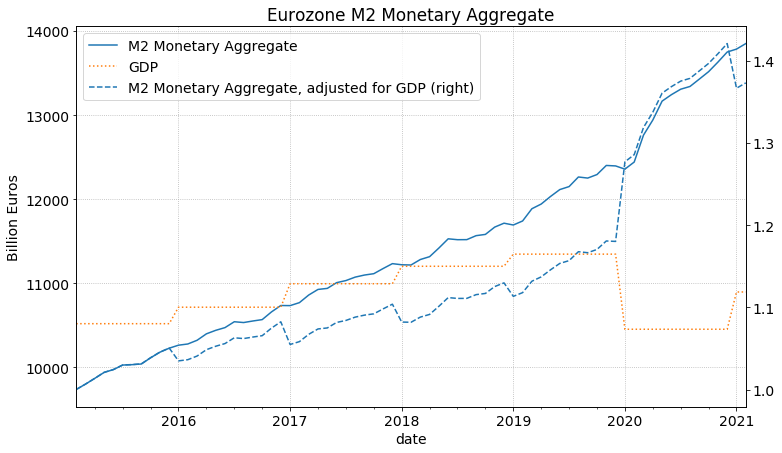

In [11]:
plot_gdp(m2, gdp, '2015-01-01', '2022-01-01', 'Euros')
plt.title('Eurozone M2 Monetary Aggregate')
plt.show()

## Market Valuation Relative to M2 ##

In [12]:
msci = pd.read_csv('./csv/LU1646360971-MFE.csv')
msci['date'] = pd.to_datetime(msci['date'])

In [13]:
def plot_market(mkt, m2, start_date, label):
    sel = mkt[mkt.date > start_date][['date', 'close']]
    sel = sel.merge(m2, on=['date'], how='outer')
    sel['mfe'] = sel['close']
    sel = sel[['date', 'mfe', 'm2']]
    sel = sel.sort_values('date').reset_index(drop=True)
    sel['m2'] = sel['m2'].fillna(method='ffill')
    sel = sel[sel['date'] > start_date]
    sel = sel.sort_values('date').reset_index(drop=True)
    sel['mfe_adjusted'] = (sel['mfe'] / sel['mfe'].loc[0])  * (sel['m2'].loc[0] / sel['m2'])
    fig, ax = plt.subplots(figsize=(12, 7))
    sel.plot(x='date', y='mfe', label=label, ax=ax)
    plt.ylabel('Euros')
    plt.grid(linestyle=':')
    ax2 = sel.plot(x='date', y='mfe_adjusted', label=f'{label}, adjusted for M2', ax=ax, secondary_y=True, color = 'red', linestyle='--')
    ax.grid(linestyle=':')
    plt.xlabel('')

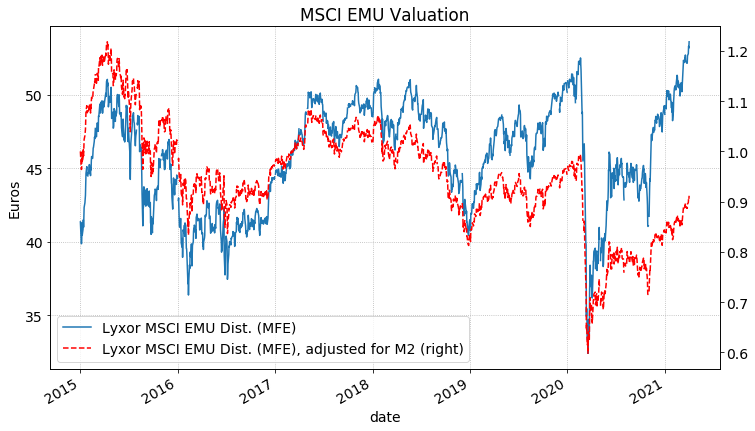

In [14]:
plot_market(msci, m2, '2015-01-01', 'Lyxor MSCI EMU Dist. (MFE)')
plt.title('MSCI EMU Valuation')
plt.show()

# United States of America #

## M2 Monetary Aggregate ##

In [15]:
# Fetch data from FRED
resp = requests.get(
    'https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&'
    'height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&'
    'show_axis_titles=yes&show_tooltip=yes&id=M2SL&scale=left&cosd=1959-01-01&coed=2021-02-01'
    '&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly'
    '&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2021-04-03&revision_date=2021-04-03&nd=1959-01-01'
)
fp = io.StringIO(resp.text)
df = pd.read_csv(fp)

In [16]:
usm2 = df
usm2.columns = [c.lower() for c in usm2.columns]
usm2['date'] = pd.to_datetime(usm2['date']) 
usm2 = usm2.rename(
    columns = {'m2sl': 'm2'}
)

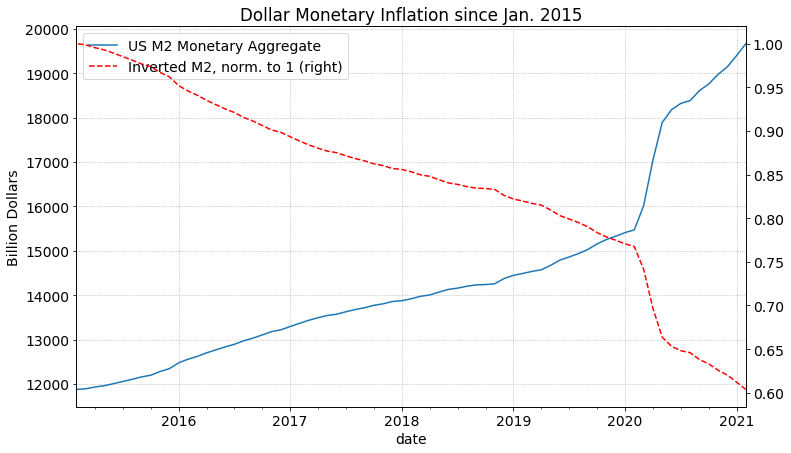

In [17]:
plot_m2(usm2, '2015-01-01', 'US', 'Dollars')
plt.title('Dollar Monetary Inflation since Jan. 2015')
plt.show()

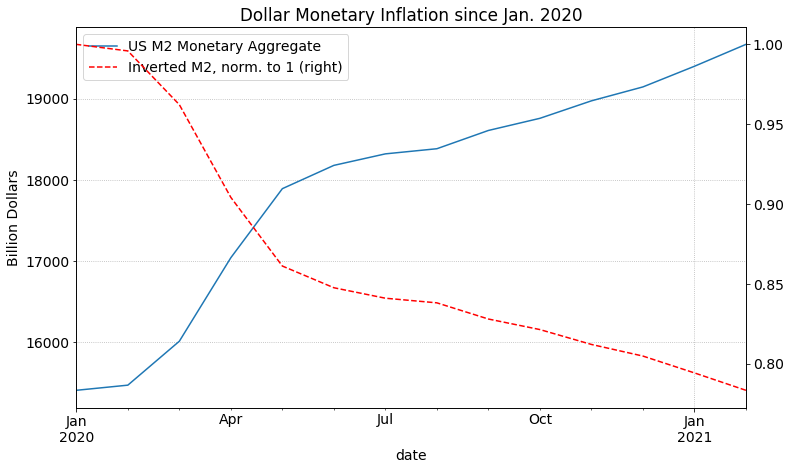

In [18]:
plot_m2(usm2, '2019-12-31', 'US', 'Dollars')
plt.title('Dollar Monetary Inflation since Jan. 2020')
plt.show()

## M2 Relative to GDP ##

In [19]:
# Fetch data from FRED
resp = requests.get(
    'https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&'
    'height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&'
    'id=GDP&scale=left&cosd=1947-01-01&coed=2020-10-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&'
    'fml=a&fq=Quarterly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2021-04-03&revision_date=2021-04-03&nd=1947-01-01'
)
fp = io.StringIO(resp.text)
df = pd.read_csv(fp)
usgdp = df

In [20]:
usgdp.columns = [c.lower() for c in usgdp.columns]
usgdp['date'] = pd.to_datetime(usgdp['date'])

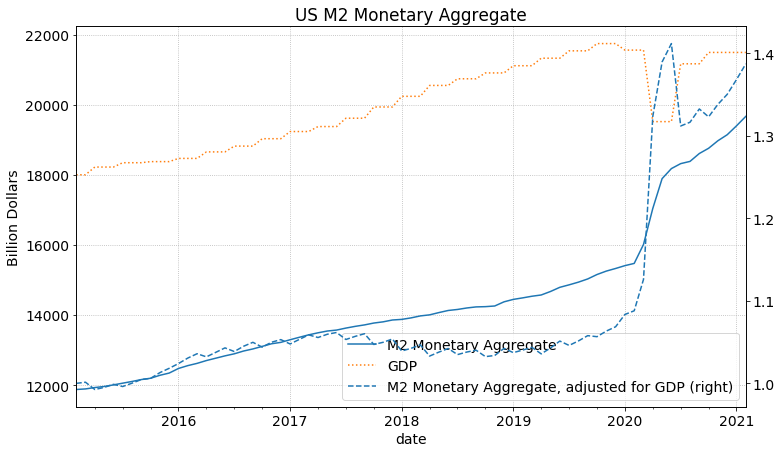

In [21]:
plot_gdp(usm2, usgdp, '2015-01-01', '2022-01-01', 'Dollars')
plt.title('US M2 Monetary Aggregate')
plt.show()

## Market Valuation Relative to M2 ##

In [22]:
spy = pd.read_csv('./csv/US78462F1030-SPY.csv')
spy['date'] = pd.to_datetime(spy['date'])

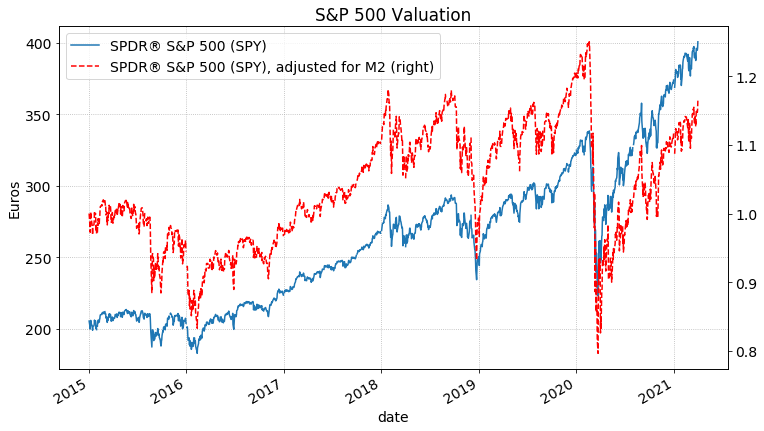

In [23]:
plot_market(spy, usm2, '2015-01-01', 'SPDR® S&P 500 (SPY)')
plt.title('S&P 500 Valuation')
plt.show()